**Lab 1 CT-221**: Predição de séries temporais


**Equipe**: Victor Hugo de Oliveira Bastos, Leonardo Antônio Lugarini, José Eduardo Teixeira Araújo, Marcel Versiani, Rafael Otero

>[Preparação dos dados](#scrollTo=PVReDV-SVMVX)

>>[Importando pacotes e dados](#scrollTo=efpR3GuWVMVc)

>>[Aplicando os modelos](#scrollTo=LHNzVtsrY7AG)

>>>[[1] 10-15-1 --- r = 15, p = 0 e tanh / Levenberg-Marquardt](#scrollTo=FUZnaVtqVSCO)

>>>[[2] 10-10-10-1 --- r = 10, p = 10 e Relu / Levenberg-Marquardt](#scrollTo=Uqu36GzdVYh8)

>>>[[3] 10-10-10-3 --- r=10 , p=10, relu / Resilient Backpropapation](#scrollTo=4pekYAa4ae7l)

>>>[[4] 10-25-10 ---  r=25 (RELU) / Polak-Ribiére Conjugate Gradient](#scrollTo=H1UzQr-bVxzV)

>>>[[5] 6-25-25-2 --- r=p=25 Tanh / Bayesian Regularization](#scrollTo=fbGBxtj_XKLv)

>>>[[6] 10-25-25-1, r = p = 25, Tanh / RMSprop](#scrollTo=ziJ-KWiOb50H)

>>[Analisando os resultados](#scrollTo=iA97S80t7h18)



 <a name='prep'></a>
#Preparação dos dados



<a name='imp'></a>
## Importando pacotes e dados

In [1]:
# Importing the necessary Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing scipy.stats for Q-Q plots
import scipy.stats as stats
plt.style.use('ggplot')

# Importing train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Importing OrdinalEncoder from sklearn.compose and sklearn.preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

# Importing KBinsDiscretizer from sklearn.preprocessing
from sklearn.preprocessing import KBinsDiscretizer

# Importing MinMaxScaler from sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler

# Importing KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

# Importing DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Importing GaussianNB from sklearn.naive_bayes
from sklearn.naive_bayes import GaussianNB

# Importing metrics from sklearn.metrics
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    roc_curve,
    roc_auc_score
)

# Importing GridSearchCV from sklearn.model_selection
from sklearn.model_selection import GridSearchCV

# Importing PowerTransformer and FunctionTransformer from sklearn.preprocessing
from sklearn.preprocessing import PowerTransformer, FunctionTransformer

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
#from keras.utils.vis_utils import plot_model
from keras.utils import plot_model
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


Por conveniência, optou-se por adquirir os dados a partir da leitura do Google Drive.

In [2]:
# Carregando os dados...

def carregar_dados(url):
  # URL dos arquivos CSV
  url_data = url
  # Extração do identificador do arquivo da URL
  identificador = url.split('/')[-2]
  # Construção do link de download direto do arquivo
  url_download = 'https://drive.google.com/uc?id=' + identificador

  #Retorna dataframe
  return pd.read_csv(url_download, on_bad_lines='skip', sep=',',parse_dates=['Date'], index_col=['Date'])


# URL dos arquivos CSV
url_data_embr = 'https://drive.google.com/file/d/1JkBgws5aVCpP9Xunv_51Pkhv8QdM6ZKT/view?usp=drive_link'
url_data_petr = 'httpsn://drive.google.com/file/d/1tvv9iIqA9bOpR31c545e59oOzbkXxmpv/view?usp=drive_link'
url_data_vale = 'https://drive.google.com/file/d/1JxYLJ9EQHnN0XGUmOBdd7as_EDsV9CKX/view?usp=drive_link'

embr = carregar_dados(url_data_embr)
petr = carregar_dados(url_data_petr)
vale = carregar_dados(url_data_vale)

In [3]:
petr.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,16.990000,17.330000,16.980000,17.330000,6.917481,4488000
2018-01-03,17.240000,17.670000,17.209999,17.549999,7.005296,9771700
2018-01-04,17.670000,17.900000,17.629999,17.700001,7.065169,6816500
2018-01-05,17.690001,17.850000,17.600000,17.840000,7.121052,4646500
2018-01-08,17.639999,18.120001,17.610001,18.120001,7.232818,4763400


<a name='ana'></a>
## Aplicando os modelos

In [4]:
petr_close = petr[:-90]['Close']
embr_close = embr[:-90]['Close']
vale_close = vale[:-90]['Close']

<a name='ana'></a>
###[1] 10-15-1 --- r = 15, p = 0 e tanh / Levenberg-Marquardt

In [5]:
r_1 = 15
p_1 = 0

# Função para criar amostras NARMAX
def create_narmax_samples(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX
def create_narmax_model(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(r, activation='tanh', input_shape=(sequence_length, num_features)),
        tf.keras.layers.Dense(1, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX
def train_narmax_model(model, X_train, y_train, X_test, y_test, num_epochs=50):
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Função para fazer previsões
def make_predictions(model, last_10_days, num_predictions):
    predicted_data = []
    for _ in range(num_predictions):
        prediction_petr = model[0].predict(np.array([last_10_days]))[0][0]
        prediction_embr = model[2].predict(np.array([last_10_days]))[0][0]
        prediction_vale = model[1].predict(np.array([last_10_days]))[0][0]
        prediction = [prediction_petr, prediction_embr, prediction_vale]
        predicted_data.append(prediction)
        last_10_days = np.concatenate((last_10_days[1:], [prediction]), axis=0)
    return predicted_data

# Combine os dados de fechamento em um único array
combined_data_1 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_1 = MinMaxScaler()
normalized_data_1 = scaler_1.fit_transform(combined_data_1)

# Dividir os dados em treinamento e teste
train_size_1 = int(0.8 * normalized_data_1.shape[0])
train_data_1 = normalized_data_1[:train_size_1]
test_data_1 = normalized_data_1[train_size_1:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_1 = 10

# Crie amostras NARMAX para treinamento e teste
X_train_1, y_train_1 = create_narmax_samples(train_data_1, sequence_length_1)
X_test_1, y_test_1 = create_narmax_samples(test_data_1, sequence_length_1)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR
model_petr_1 = create_narmax_model(r_1, p_1, sequence_length_1, normalized_data_1.shape[1])
train_narmax_model(model_petr_1, X_train_1, y_train_1[:, 0], X_test_1, y_test_1[:, 0])

model_vale_1 = create_narmax_model(r_1, p_1, sequence_length_1, normalized_data_1.shape[1])
train_narmax_model(model_vale_1, X_train_1, y_train_1[:, 1], X_test_1, y_test_1[:, 1])

model_embr_1 = create_narmax_model(r_1, p_1, sequence_length_1, normalized_data_1.shape[1])
train_narmax_model(model_embr_1, X_train_1, y_train_1[:, 2], X_test_1, y_test_1[:, 2])

# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_1 = normalized_data_1[-sequence_length_1:, :]

predicted_1 = make_predictions([model_petr_1,
                              model_vale_1,
                              model_embr_1],
                              last_10_days_1, 90)

# Imprima as previsões
petr_predictions_1 = []
embr_predictions_1 = []
vale_predictions_1 = []

for i in predicted_1:
    petr_predictions_1.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_1.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_1.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

Epoch 1/50
32/32 [==============================] - 2s 18ms/step - loss: 0.1022 - val_loss: 0.0512
Epoch 2/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0083 - val_loss: 0.0180
Epoch 3/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0065 - val_loss: 0.0192
Epoch 4/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0055 - val_loss: 0.0152
Epoch 5/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0126
Epoch 6/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0098
Epoch 7/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0083
Epoch 8/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0070
Epoch 9/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0064
Epoch 10/50
32/32 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0055
Epoch 11/50
32/32 

In [6]:
plot_model(model_petr_1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [36]:
print("Previsão para os próximos 90 dias de PETR:")
print(petr_predictions_1)

print("Previsão para os próximos 90 dias de VALE:")
print(vale_predictions_1)

print("Previsão para os próximos 90 dias de EMBR:")
print(embr_predictions_1)

Previsão para os próximos 90 dias de PETR:
[27.457947991645636, 27.359297773144124, 27.269771158643245, 27.233616809204044, 27.256035742853584, 27.316165694274904, 27.41139342469007, 27.52603222728038, 27.653588103663086, 27.784444626101436, 27.928376435118317, 28.00474956591648, 28.08305580236596, 28.165644695267797, 28.251290550163866, 28.33863310080093, 28.426132045686366, 28.512807192961215, 28.59778564449507, 28.680621858533858, 28.761117614460467, 28.838760084623278, 28.914456719370364, 28.988263893372654, 29.060261622292103, 29.130513554950713, 29.19904878795284, 29.265880051062883, 29.331016436969698, 29.394445215908885, 29.456168206418216, 29.516198138262094, 29.574578656347036, 29.63131521628636, 29.686446007373274, 29.74000012621212, 29.792033947473826, 29.842576567762734, 29.89167526906091, 29.93935732943493, 29.985664575253548, 30.03062064750779, 30.07426373549086, 30.11662475434488, 30.157736437749744, 30.197638793536424, 30.236355462695958, 30.273930090134858, 30.3103881

<a name='ana'></a>
###[2] 10-10-10-1 --- r = 10, p = 10 e Relu / Levenberg-Marquardt

In [ ]:
# Renamed variables
r_2 = 10
p_2 = 10

# Função para criar amostras NARMAX
def create_narmax_samples_2(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX
def create_narmax_model_2(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(r, activation='relu', input_shape=(sequence_length, num_features)),
        tf.keras.layers.Dense(p, activation='relu'),
        tf.keras.layers.Dense(1, activation='relu')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX
def train_narmax_model_2(model, X_train, y_train, X_test, y_test, num_epochs=50):
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Função para fazer previsões
def make_predictions_2(model, last_10_days, num_predictions):
    predicted_data = []
    for _ in range(num_predictions):
        prediction_petr = model[0].predict(np.array([last_10_days]))[0][0]
        prediction_embr = model[2].predict(np.array([last_10_days]))[0][0]
        prediction_vale = model[1].predict(np.array([last_10_days]))[0][0]
        prediction = [prediction_petr, prediction_embr, prediction_vale]
        predicted_data.append(prediction)
        last_10_days = np.concatenate((last_10_days[1:], [prediction]), axis=0)
    return predicted_data

# Combine os dados de fechamento em um único array
combined_data_2 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_2 = MinMaxScaler()
normalized_data_2 = scaler_2.fit_transform(combined_data_2)

# Dividir os dados em treinamento e teste
train_size_2 = int(0.8 * normalized_data_2.shape[0])
train_data_2 = normalized_data_2[:train_size_2]
test_data_2 = normalized_data_2[train_size_2:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_2 = 10

# Crie amostras NARMAX para treinamento e teste
X_train_2, y_train_2 = create_narmax_samples_2(train_data_2, sequence_length_2)
X_test_2, y_test_2 = create_narmax_samples_2(test_data_2, sequence_length_2)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR
model_petr_2 = create_narmax_model_2(r_2, p_2, sequence_length_2, normalized_data_2.shape[1])
train_narmax_model_2(model_petr_2, X_train_2, y_train_2[:, 0], X_test_2, y_test_2[:, 0])

model_vale_2 = create_narmax_model_2(r_2, p_2, sequence_length_2, normalized_data_2.shape[1])
train_narmax_model_2(model_vale_2, X_train_2, y_train_2[:, 1], X_test_2, y_test_2[:, 1])

model_embr_2 = create_narmax_model_2(r_2, p_2, sequence_length_2, normalized_data_2.shape[1])
train_narmax_model_2(model_embr_2, X_train_2, y_train_2[:, 2], X_test_2, y_test_2[:, 2])

# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_2 = normalized_data_2[-sequence_length_2:, :]

predicted_2 = make_predictions_2([model_petr_2,
                              model_vale_2,
                              model_embr_2],
                              last_10_days_2, 90)

# Imprima as previsões
petr_predictions_2 = []
embr_predictions_2 = []
vale_predictions_2 = []

for i in predicted_2:
    petr_predictions_2.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_2.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_2.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

Epoch 1/50
32/32 [==============================] - 2s 13ms/step - loss: 0.2029 - val_loss: 0.2961
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0480 - val_loss: 0.0591
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0154 - val_loss: 0.0396
Epoch 4/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0086 - val_loss: 0.0214
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0042 - val_loss: 0.0074
Epoch 6/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 7/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 8/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 9/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 10/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 11/50
32/32 

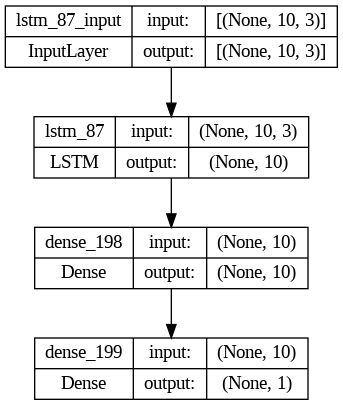

In [ ]:
plot_model(model_petr_2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
print("Previsão para os próximos 90 dias de PETR:")
print(petr_predictions_2)

print("Previsão para os próximos 90 dias de VALE:")
print(vale_predictions_2)

print("Previsão para os próximos 90 dias de EMBR:")
print(embr_predictions_2)

Previsão para os próximos 90 dias de PETR:
[26.144017171566755, 26.229225668128727, 26.170165926186055, 26.305687907277704, 26.32601915956533, 26.393052280368032, 26.494957681480884, 26.574400504037676, 26.67250152413213, 26.78485078766787, 26.89338657749635, 26.979959886655987, 27.06074842716384, 27.14022034632498, 27.22104525758827, 27.30168285946107, 27.38158395353633, 27.45979017040837, 27.536137841677725, 27.6102287075724, 27.681953655826092, 27.75146362507385, 27.819395103535772, 27.88578264342952, 27.950629881830633, 28.01375860203749, 28.075116066454708, 28.134516784229575, 28.191697067385196, 28.24659508563733, 28.29877075284523, 28.34589634066111, 28.38939940123576, 28.428154259688498, 28.462444607911706, 28.492619605157554, 28.518948395016253, 28.54119456757748, 28.559474509258628, 28.57398644067681, 28.584863115089355, 28.592146358865023, 28.59440861985302, 28.592362764859857, 28.585985152894498, 28.574901165175973, 28.559276288641513, 28.53877773087889, 28.51383466680223, 

<a name='ana'></a>
###[3] 10-10-10-3 --- r=10 , p=10, relu / Resilient Backpropapation

In [ ]:
r_3 = 10
p_3 = 10

# Função para criar amostras NARMAX
def create_narmax_samples_3(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX
def create_narmax_model_3(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(r, activation='relu', input_shape=(sequence_length, num_features)),
        tf.keras.layers.Dense(p, activation='relu'),
        tf.keras.layers.Dense(3, activation='relu')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX com algoritmo Resilient Backpropagation
def train_narmax_model_rp_3(model, X_train, y_train, X_test, y_test, num_epochs=50):
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
    model.compile(optimizer=optimizer, loss='mse')
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Função para fazer previsões
def make_predictions_3(model, last_10_days, num_predictions):
    predicted_data = []
    for _ in range(num_predictions):
        prediction_petr = model[0].predict(np.array([last_10_days]))[0][0]
        prediction_embr = model[2].predict(np.array([last_10_days]))[0][0]
        prediction_vale = model[1].predict(np.array([last_10_days]))[0][0]
        prediction = [prediction_petr, prediction_embr, prediction_vale]
        predicted_data.append(prediction)
        last_10_days = np.concatenate((last_10_days[1:], [prediction]), axis=0)
    return predicted_data

# Combine os dados de fechamento em um único array
combined_data_3 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_3 = MinMaxScaler()
normalized_data_3 = scaler_3.fit_transform(combined_data_3)

# Dividir os dados em treinamento e teste
train_size_3 = int(0.8 * normalized_data_3.shape[0])
train_data_3 = normalized_data_3[:train_size_3]
test_data_3 = normalized_data_3[train_size_3:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_3 = 10

# Crie amostras NARMAX para treinamento e teste
X_train_3, y_train_3 = create_narmax_samples_3(train_data_3, sequence_length_3)
X_test_3, y_test_3 = create_narmax_samples_3(test_data_3, sequence_length_3)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR usando train_narmax_model_rp_3
model_petr_3 = create_narmax_model_3(r_3, p_3, sequence_length_3, normalized_data_3.shape[1])
train_narmax_model_rp_3(model_petr_3, X_train_3, y_train_3[:, 0], X_test_3, y_test_3[:, 0])

model_vale_3 = create_narmax_model_3(r_3, p_3, sequence_length_3, normalized_data_3.shape[1])
train_narmax_model_rp_3(model_vale_3, X_train_3, y_train_3[:, 1], X_test_3, y_test_3[:, 1])

model_embr_3 = create_narmax_model_3(r_3, p_3, sequence_length_3, normalized_data_3.shape[1])
train_narmax_model_rp_3(model_embr_3, X_train_3, y_train_3[:, 2], X_test_3, y_test_3[:, 2])

# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_3 = normalized_data_3[-sequence_length_3:, :]

predicted_3 = make_predictions_3([model_petr_3,
                              model_vale_3,
                              model_embr_3],
                              last_10_days_3, 90)

# Imprima as previsões
petr_predictions_3 = []
embr_predictions_3 = []
vale_predictions_3 = []

for i in predicted_3:
    petr_predictions_3.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_3.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_3.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

Epoch 1/50
32/32 [==============================] - 2s 19ms/step - loss: 0.1076 - val_loss: 0.0323
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0049 - val_loss: 0.0071
Epoch 4/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0035 - val_loss: 0.0056
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 6/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 7/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0028 - val_loss: 0.0050
Epoch 8/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0027 - val_loss: 0.0040
Epoch 9/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0039
Epoch 10/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0040
Epoch 11/50
32/3

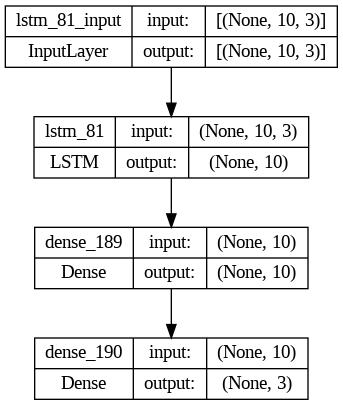

In [ ]:
plot_model(model_petr_3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
print("Previsão para os próximos 90 dias de PETR:")
print(petr_predictions_3)

print("Previsão para os próximos 90 dias de VALE:")
print(vale_predictions_3)

print("Previsão para os próximos 90 dias de EMBR:")
print(embr_predictions_3)

Previsão para os próximos 90 dias de PETR:
[26.889776780019524, 26.9002661058867, 26.932108702269197, 26.96703008309919, 26.999330951000154, 27.038838684090376, 27.081343367428364, 27.129729201920032, 27.178947926711142, 27.22588984221208, 27.281364336937845, 27.321083020409585, 27.359725129520477, 27.397112447568894, 27.433146773515166, 27.467799010754945, 27.500987325088502, 27.532717172129153, 27.562957636734783, 27.591745089660822, 27.619185006098032, 27.645208281611087, 27.670147708612205, 27.69399419441253, 27.716782291229727, 27.738548369819224, 27.759328800936462, 27.7791708665635, 27.798103663304687, 27.816179928755403, 27.833396025840102, 27.849817421918573, 27.865484124821783, 27.880425231154085, 27.894677111670912, 27.90826522590107, 27.92121685191113, 27.933557449229895, 27.94531793299949, 27.956516488597632, 27.967185849704205, 27.977335109008074, 27.986993363113584, 27.99614788225633, 28.004840492805062, 28.013091198675276, 28.020923640857994, 28.028348730579854, 28.0353

<a name='ana'></a>
###[4] 10-25-10 ---  r=25 (RELU) / Polak-Ribiére Conjugate Gradient

In [ ]:
r_4 = 25
p_4 = 0

# Função para criar amostras NARMAX
def create_narmax_samples_4(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX
def create_narmax_model_4(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(r, activation='relu', input_shape=(sequence_length, num_features)),
        tf.keras.layers.Dense(10, activation='relu')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX com algoritmo Polak-Ribière Conjugate Gradient
def train_narmax_model_cgp_4(model, X_train, y_train, X_test, y_test, num_epochs=50):
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=optimizer, loss='mse')
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Função para fazer previsões
def make_predictions_4(model, last_10_days, num_predictions):
    predicted_data = []
    for _ in range(num_predictions):
        prediction_petr = model[0].predict(np.array([last_10_days]))[0][0]
        prediction_embr = model[2].predict(np.array([last_10_days]))[0][0]
        prediction_vale = model[1].predict(np.array([last_10_days]))[0][0]
        prediction = [prediction_petr, prediction_embr, prediction_vale]
        predicted_data.append(prediction)
        last_10_days = np.concatenate((last_10_days[1:], [prediction]), axis=0)
    return predicted_data

# Combine os dados de fechamento em um único array
combined_data_4 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_4 = MinMaxScaler()
normalized_data_4 = scaler_4.fit_transform(combined_data_4)

# Dividir os dados em treinamento e teste
train_size_4 = int(0.8 * normalized_data_4.shape[0])
train_data_4 = normalized_data_4[:train_size_4]
test_data_4 = normalized_data_4[train_size_4:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_4 = 10

# Crie amostras NARMAX para treinamento e teste
X_train_4, y_train_4 = create_narmax_samples_4(train_data_4, sequence_length_4)
X_test_4, y_test_4 = create_narmax_samples_4(test_data_4, sequence_length_4)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR usando train_narmax_model_cgp_4
model_petr_4 = create_narmax_model_4(r_4, p_4, sequence_length_4, normalized_data_4.shape[1])
train_narmax_model_cgp_4(model_petr_4, X_train_4, y_train_4[:, 0], X_test_4, y_test_4[:, 0])

model_vale_4 = create_narmax_model_4(r_4, p_4, sequence_length_4, normalized_data_4.shape[1])
train_narmax_model_cgp_4(model_vale_4, X_train_4, y_train_4[:, 1], X_test_4, y_test_4[:, 1])

model_embr_4 = create_narmax_model_4(r_4, p_4, sequence_length_4, normalized_data_4.shape[1])
train_narmax_model_cgp_4(model_embr_4, X_train_4, y_train_4[:, 2], X_test_4, y_test_4[:, 2])

# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_4 = normalized_data_4[-sequence_length_4:, :]

predicted_4 = make_predictions_4([model_petr_4,
                              model_vale_4,
                              model_embr_4],
                              last_10_days_4, 90)

# Imprima as previsões
petr_predictions_4 = []
embr_predictions_4 = []
vale_predictions_4 = []

for i in predicted_4:
    petr_predictions_4.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_4.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_4.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

Epoch 1/50
32/32 [==============================] - 1s 13ms/step - loss: 0.2037 - val_loss: 0.2064
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0453 - val_loss: 0.0688
Epoch 3/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0184 - val_loss: 0.0427
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0161 - val_loss: 0.0380
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0151 - val_loss: 0.0370
Epoch 6/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0143 - val_loss: 0.0348
Epoch 7/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0134 - val_loss: 0.0331
Epoch 8/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0126 - val_loss: 0.0319
Epoch 9/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0119 - val_loss: 0.0299
Epoch 10/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0111 - val_loss: 0.0285
Epoch 11/50
32/32 

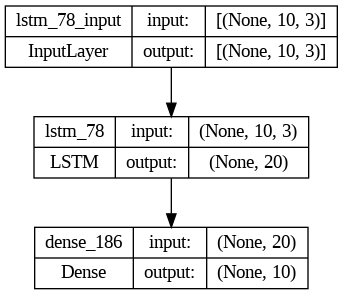

In [ ]:
plot_model(model_petr_4, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
print("Previsão para os próximos 90 dias de PETR:")
print(petr_predictions_4)

print("Previsão para os próximos 90 dias de VALE:")
print(vale_predictions_4)

print("Previsão para os próximos 90 dias de EMBR:")
print(embr_predictions_4)

Previsão para os próximos 90 dias de PETR:
[27.626573725064457, 27.568109554242014, 27.53319362902534, 27.521847771867694, 27.528270847277344, 27.574607189700306, 27.64539559100157, 27.743676646335423, 27.84992289710933, 27.955045291540326, 28.08774762981695, 28.133372923971177, 28.183379075617434, 28.24024657027632, 28.30039652561313, 28.36225590645534, 28.423309675064683, 28.482104819761574, 28.537381093870223, 28.58854019846374, 28.635620322835326, 28.67733030516708, 28.71770184369886, 28.756433061160564, 28.79319662075329, 28.827717923273504, 28.85977328857529, 28.889268152694523, 28.916177056102395, 28.940547280780972, 28.96246247946775, 28.98201721612686, 28.999356973780035, 29.014432651907445, 29.02705875965637, 29.036951605134426, 29.044485807122587, 29.049592261185527, 29.052090932083846, 29.05190362269336, 29.049341302973033, 29.044409428536177, 29.037107999382794, 29.027397007681905, 29.014741803328633, 28.999280595193625, 28.981349812764645, 28.960964004343868, 28.938128625

<a name='ana'></a>
###[5] 6-25-25-2 --- r=p=25 Tanh / Bayesian Regularization

In [ ]:
r_5 = 25
p_5 = 25

# Função para criar amostras NARMAX
def create_narmax_samples_5(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX com Bayesian Regularization
def create_narmax_model_5(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(r, activation='tanh', input_shape=(sequence_length, num_features),
                             kernel_regularizer=tf.keras.regularizers.L2(0.01),
                             recurrent_regularizer=tf.keras.regularizers.L2(0.01)),
        tf.keras.layers.Dense(p, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        tf.keras.layers.Dense(2, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX com algoritmo Bayesian Regularization
def train_narmax_model_br_5(model, X_train, y_train, X_test, y_test, num_epochs=50):
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Função para fazer previsões
def make_predictions_5(model, last_10_days, num_predictions):
    predicted_data = []
    for _ in range(num_predictions):
        prediction_petr = model[0].predict(np.array([last_10_days]))[0][0]
        prediction_embr = model[2].predict(np.array([last_10_days]))[0][0]
        prediction_vale = model[1].predict(np.array([last_10_days]))[0][0]
        prediction = [prediction_petr, prediction_embr, prediction_vale]
        predicted_data.append(prediction)
        last_10_days = np.concatenate((last_10_days[1:], [prediction]), axis=0)
    return predicted_data

combined_data_5 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_5 = MinMaxScaler()
normalized_data_5 = scaler_5.fit_transform(combined_data_5)

# Dividir os dados em treinamento e teste
train_size_5 = int(0.8 * normalized_data_5.shape[0])
train_data_5 = normalized_data_5[:train_size_5]
test_data_5 = normalized_data_5[train_size_5:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_5 = 6

# Crie amostras NARMAX para treinamento e teste
X_train_5, y_train_5 = create_narmax_samples_5(train_data_5, sequence_length_5)
X_test_5, y_test_5 = create_narmax_samples_5(test_data_5, sequence_length_5)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR
model_petr_5 = create_narmax_model_5(r_5, p_5, sequence_length_5, normalized_data_5.shape[1])
train_narmax_model_br_5(model_petr_5, X_train_5, y_train_5[:, 0], X_test_5, y_test_5[:, 0])

model_vale_5 = create_narmax_model_5(r_5, p_5, sequence_length_5, normalized_data_5.shape[1])
train_narmax_model_br_5(model_vale_5, X_train_5, y_train_5[:, 1], X_test_5, y_test_5[:, 1])

model_embr_5 = create_narmax_model_5(r_5, p_5, sequence_length_5, normalized_data_5.shape[1])
train_narmax_model_br_5(model_embr_5, X_train_5, y_train_5[:, 2], X_test_5, y_test_5[:, 2])

# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_5 = normalized_data_5[-sequence_length_5:, :]

predicted_5 = make_predictions_5([model_petr_5,
                              model_vale_5,
                              model_embr_5],
                              last_10_days_5, 90)

# Imprima as previsões
petr_predictions_5 = []
embr_predictions_5 = []
vale_predictions_5 = []

for i in predicted_5:
    petr_predictions_5.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_5.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_5.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

Epoch 1/50
33/33 [==============================] - 6s 28ms/step - loss: 0.5504 - val_loss: 0.4463
Epoch 2/50
33/33 [==============================] - 0s 7ms/step - loss: 0.3694 - val_loss: 0.3284
Epoch 3/50
33/33 [==============================] - 0s 7ms/step - loss: 0.2653 - val_loss: 0.2442
Epoch 4/50
33/33 [==============================] - 0s 6ms/step - loss: 0.1925 - val_loss: 0.1837
Epoch 5/50
33/33 [==============================] - 0s 7ms/step - loss: 0.1413 - val_loss: 0.1419
Epoch 6/50
33/33 [==============================] - 0s 7ms/step - loss: 0.1052 - val_loss: 0.1112
Epoch 7/50
33/33 [==============================] - 0s 7ms/step - loss: 0.0795 - val_loss: 0.0841
Epoch 8/50
33/33 [==============================] - 0s 6ms/step - loss: 0.0614 - val_loss: 0.0672
Epoch 9/50
33/33 [==============================] - 0s 10ms/step - loss: 0.0482 - val_loss: 0.0629
Epoch 10/50
33/33 [==============================] - 0s 11ms/step - loss: 0.0388 - val_loss: 0.0488
Epoch 11/50
33/3

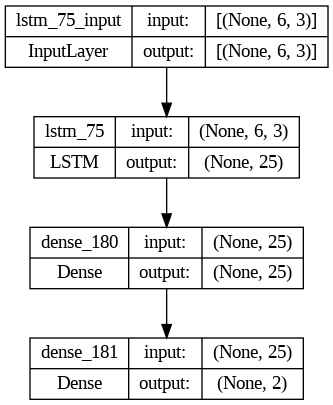

In [ ]:
plot_model(model_petr_5, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
print("Previsão para os próximos 90 dias de PETR:")
print(petr_predictions_5)

print("Previsão para os próximos 90 dias de VALE:")
print(vale_predictions_5)

print("Previsão para os próximos 90 dias de EMBR:")
print(embr_predictions_5)

Previsão para os próximos 90 dias de PETR:
[27.01621243713486, 26.912815835049212, 26.874744746798633, 26.953512891842127, 27.061146686935842, 27.16595083725679, 27.40126235076392, 27.45642587553072, 27.538852918570875, 27.64232044362962, 27.74918499724591, 27.855518537832857, 27.962343083618165, 28.04699237981534, 28.137177304989578, 28.228944358025192, 28.318780123947263, 28.405771696794393, 28.489515361181258, 28.56932734690571, 28.64833190185952, 28.72552519319272, 28.800372570800423, 28.87281947854948, 28.94294956917739, 29.010897414479256, 29.076968528800727, 29.140966510062455, 29.202862261660098, 29.262717613877893, 29.320601671151163, 29.37658353791523, 29.430714133227706, 29.482997094164134, 29.533479702706575, 29.582205603761555, 29.629236627613306, 29.674612782092808, 29.71838498625767, 29.760589610863327, 29.801277574967383, 29.840503434702992, 29.878303560825586, 29.91473614654386, 29.949830288462163, 29.98364781686473, 30.01621782835591, 30.04759124199331, 30.07781897683

<a name='ana'></a>
###[6] 10-25-25-1, r = p = 25, Tanh / RMSprop

In [ ]:
r_6 = 25
p_6 = 25

# Função para criar amostras NARMAX
def create_narmax_samples_6(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX
def create_narmax_model_6(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
    tf.keras.layers.LSTM(r, activation='tanh', input_shape=(sequence_length, num_features)),
    tf.keras.layers.Dense(p, activation='tanh'),
    tf.keras.layers.Dense(1, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX com algoritmo RMSprop
def train_narmax_model_rp_6(model, X_train, y_train, X_test, y_test, num_epochs=50):
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
    model.compile(optimizer=optimizer, loss='mse')
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Função para fazer previsões
def make_predictions_6(model, last_10_days, num_predictions):
    predicted_data = []
    for _ in range(num_predictions):
        prediction_petr = model[0].predict(np.array([last_10_days]))[0][0]
        prediction_embr = model[2].predict(np.array([last_10_days]))[0][0]
        prediction_vale = model[1].predict(np.array([last_10_days]))[0][0]
        prediction = [prediction_petr, prediction_embr, prediction_vale]
        predicted_data.append(prediction)
        last_10_days = np.concatenate((last_10_days[1:], [prediction]), axis=0)
    return predicted_data

combined_data_6 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_6 = MinMaxScaler()
normalized_data_6 = scaler_6.fit_transform(combined_data_6)

# Dividir os dados em treinamento e teste
train_size_6 = int(0.8 * normalized_data_6.shape[0])
train_data_6 = normalized_data_6[:train_size_6]
test_data_6 = normalized_data_6[train_size_6:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_6 = 10

# Crie amostras NARMAX para treinamento e teste
X_train_6, y_train_6 = create_narmax_samples_6(train_data_6, sequence_length_6)
X_test_6, y_test_6 = create_narmax_samples_6(test_data_6, sequence_length_6)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR
model_petr_6 = create_narmax_model_6(r_6, p_6, sequence_length_6, normalized_data_6.shape[1])
train_narmax_model_rp_6(model_petr_6, X_train_6, y_train_6[:, 0], X_test_6, y_test_6[:, 0])

model_vale_6 = create_narmax_model_6(r_6, p_6, sequence_length_6, normalized_data_6.shape[1])
train_narmax_model_rp_6(model_vale_6, X_train_6, y_train_6[:, 1], X_test_6, y_test_6[:, 1])

model_embr_6 = create_narmax_model_6(r_6, p_6, sequence_length_6, normalized_data_6.shape[1])
train_narmax_model_rp_6(model_embr_6, X_train_6, y_train_6[:, 2], X_test_6, y_test_6[:, 2])

# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_6 = normalized_data_6[-sequence_length_6:, :]

predicted_6 = make_predictions_6([model_petr_6,
                              model_vale_6,
                              model_embr_6],
                              last_10_days_6, 90)

# Imprima as previsões
petr_predictions_6 = []
embr_predictions_6 = []
vale_predictions_6 = []

for i in predicted_6:
    petr_predictions_6.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_6.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_6.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

Epoch 1/50
32/32 [==============================] - 3s 31ms/step - loss: 0.0105 - val_loss: 0.0056
Epoch 2/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 3/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 5/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 6/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.0039
Epoch 7/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0046
Epoch 8/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 9/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0067
Epoch 10/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0054
Epoch 11/50
32

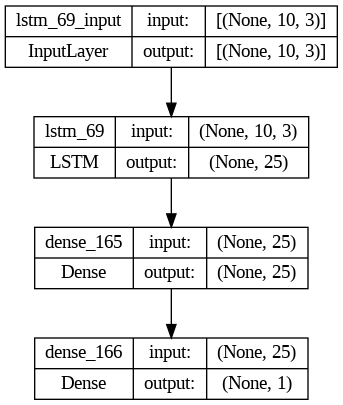

In [ ]:
plot_model(model_petr_6, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
print("Previsão para os próximos 90 dias de PETR:")
print(petr_predictions_6)

print("Previsão para os próximos 90 dias de VALE:")
print(vale_predictions_6)

print("Previsão para os próximos 90 dias de EMBR:")
print(embr_predictions_6)

Previsão para os próximos 90 dias de PETR:
[26.460198150512575, 26.687700862828017, 26.96104891236806, 27.29495063263023, 27.67240633252466, 28.074319546910704, 28.49407807245046, 28.922663780334055, 29.358865524405537, 29.80121938175869, 30.236706440485897, 30.680322363052607, 31.12486210280734, 31.569110876518607, 32.012384913984235, 32.45417684316594, 32.89398838471425, 33.33137945248842, 33.765877226667826, 34.19705071380055, 34.62446164628363, 35.047528092030106, 35.46580996489924, 35.8788144411549, 36.28601232630551, 36.68687260732174, 37.080847904334306, 37.46739083747393, 37.84594675272024, 38.215968270203945, 38.57692073982018, 38.9282731485396, 39.269516305786134, 39.60017011758804, 39.91977994950241, 40.227929356379505, 40.52424008236283, 40.80837569796461, 41.08005251129246, 41.3390250197472, 41.58510773247612, 41.81816789622188, 42.03811640263366, 42.24493142925823, 42.43863479854882, 42.619299252016305, 42.78704117607808, 42.942042424511314, 43.08449939939534, 43.21467033

## Analisando os resultados

<Axes: >

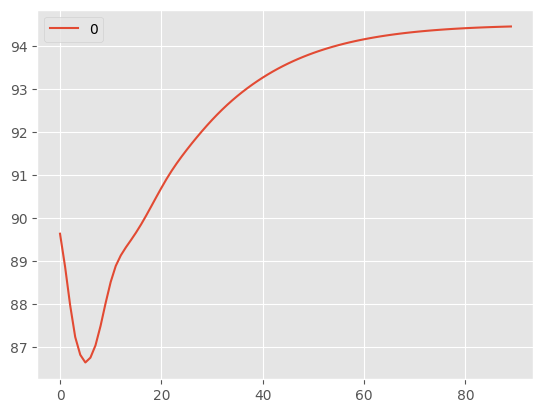

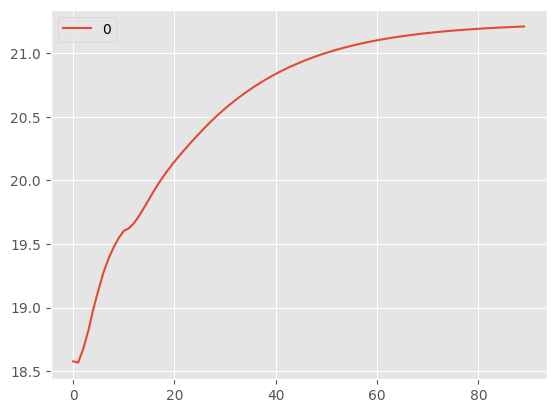

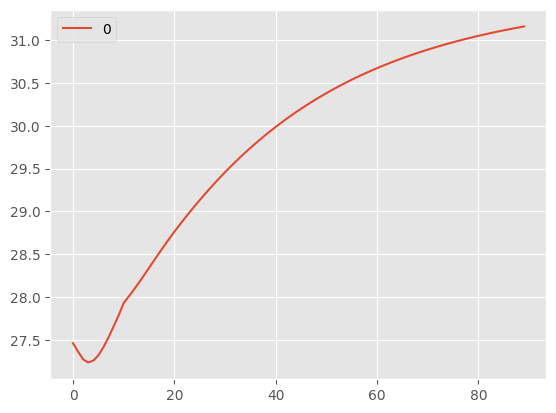

In [46]:
pd.DataFrame(vale_predictions_1).plot()
pd.DataFrame(embr_predictions_1).plot()
pd.DataFrame(petr_predictions_1).plot()